## ch3 Machine learning : single-step

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2022.09.09 </div>
<div style="text-align: right\"> Last update: 2022.09.09</div>

In [17]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [18]:
from xgboost import XGBRegressor

In [19]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

In [20]:
def load_dexcom_data(path, sampling_time='5min'):
    df = pd.read_csv(path)
    df = df[df['타임스탬프(YYYY-MM-DDThh:mm:ss)'].notnull()]
    df = df.iloc[:,[1, 7]]
    df.columns = ['timestamp', 'glucose']
    df = df.reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.round(sampling_time)
    df = df.dropna()
    idx = pd.date_range(df['timestamp'].min(), df['timestamp'].max(), freq=sampling_time)
    df = df.set_index('timestamp').reindex(idx, fill_value=np.nan).reset_index().rename(columns = {'index': 'timestamp'})
    
    return df

In [21]:
def series_to_supervised(data, n_in=1, n_out=1, col_name = 'glucose', dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]

    cols, names = list(), list()
	# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [(col_name+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
            names += [col_name+'(t)']
        else:
            names += [(col_name+'(t+%d)' % (i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### 1. 데이터 셋 만들기

In [22]:
path = 'dexcom_sample.csv'
cgm = load_dexcom_data(path)
cgm['glucose_diff'] = cgm['glucose'].diff()
cgm = cgm.dropna()
df_sv = series_to_supervised(cgm[['glucose']], n_in=4, n_out = 4, dropnan = False)
df_sv['timestamp'] = cgm['timestamp']
df_sv = df_sv.dropna().reset_index(drop = True)
# 일부만 추출
df_sv = df_sv.set_index('timestamp').loc[:'2022-06-10 21:15'].reset_index(drop=False)

In [23]:
df_sv.shape

(2760, 9)

In [24]:
df_sv.head()

,timestamp,glucose(t-4),glucose(t-3),glucose(t-2),glucose(t-1),glucose(t),glucose(t+1),glucose(t+2),glucose(t+3)
0,2022-06-01 07:20:00,122.0,125.0,128.0,129.0,129.0,130.0,128.0,127.0
1,2022-06-01 07:25:00,125.0,128.0,129.0,129.0,130.0,128.0,127.0,124.0
2,2022-06-01 07:30:00,128.0,129.0,129.0,130.0,128.0,127.0,124.0,124.0
3,2022-06-01 07:35:00,129.0,129.0,130.0,128.0,127.0,124.0,124.0,130.0
4,2022-06-01 07:40:00,129.0,130.0,128.0,127.0,124.0,124.0,130.0,137.0


In [25]:
train_index = 2735

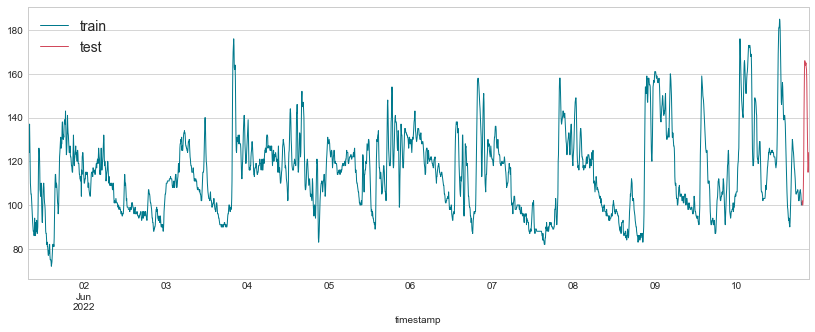

In [26]:
fig, ax = plt.subplots(figsize = (14, 5))
df_sv[:train_index].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
                                                       linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, label = 'test')
plt.legend(fontsize = 14)
plt.show()

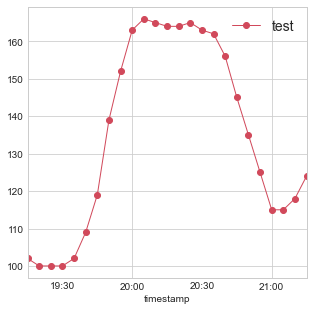

In [27]:
fig, ax = plt.subplots(figsize = (5, 5))
# df_sv[:2735].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
#                                                        linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, marker = 'o',
                                                       label = 'test')
plt.legend(fontsize = 14)
plt.show()

In [36]:
X_train = df_sv.iloc[:train_index, 1:6]
y_train = df_sv.iloc[:train_index, 6]

X_test = df_sv.iloc[train_index:, 1:6].reset_index(drop = True)
y_test = df_sv.iloc[train_index:, 6].reset_index(drop = True)

In [37]:
print(X_train.shape)
print(X_test.shape)

(2735, 5)
(25, 5)


### 2. 머신러닝 모델 학습

In [38]:
model = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [44]:
pred = model.predict(X_test)

In [45]:
pred

array([102.68203 ,  98.68921 ,  99.3327  , 100.17532 , 103.17234 ,
       118.410355, 124.629005, 147.92148 , 165.3491  , 167.45201 ,
       166.42354 , 163.93735 , 160.30757 , 159.33965 , 160.77371 ,
       159.36487 , 158.62035 , 149.00275 , 137.12138 , 129.05417 ,
       121.1545  , 110.794136, 119.09687 , 121.36074 , 128.7121  ],
      dtype=float32)

In [48]:
df_sv['pred'] = np.nan
df_sv.loc[train_index:, 'pred'] = pred

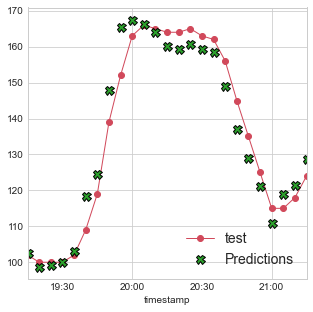

In [50]:
fig, ax = plt.subplots(figsize = (5, 5))
# df_sv[:2735].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[0],
#                                                        linewidth=1, label = 'train')
df_sv[train_index:].set_index('timestamp')['glucose(t)'].plot(ax = ax, color = colors[1], 
                                                       linewidth=1, marker = 'o',
                                                       label = 'test')

df_sv[train_index:].set_index('timestamp')['pred'].plot(ax = ax, 
                                                       linewidth=0, marker='X', 
                                                       label='Predictions',
                                                       markersize = 9,
                                                       markeredgecolor = 'k',
                                                       color='#2ca02c')

plt.legend(fontsize = 14)